## Basic Case

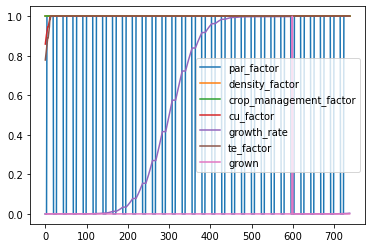

In [1]:
# 1. Load configuration file
import json
with open('data_files/config_1hrad.json') as f:
    data_files = json.load(f)
    config = data_files['config']
    user_agent_desc = data_files['agent_desc']
    user_agent_conn = data_files['agent_conn']
    
# 2. Import SIMOC
from agent_model import AgentModel

# 3. Initialize model
model = AgentModel.from_config(config, agent_desc=user_agent_desc, agent_conn=user_agent_conn)

# 4. Step the model forward
model.step_to(termination=True)

# 5. Get data from model
data = model.get_data()

# 6. Inspect data
from jupyter_scripts import plot_agent
plot_agent(data, 'radish', 'growth', exclude=['agent_step_num'])

## Custom Agent

Define an example agent, mushrooms.
- Consumes 10g o2 and 10g inedible_biomass per hour (sigmoid)
- Grow 20g per hour (normal)
- Lifetime of 30 days
- At end of lifetime, 90% edible (mushroom) 10% waste (mushroom_waste)

In [4]:
# I specify 2 new currencies:
currency_desc = {
    'food': {
        # The edible product of the mushroom plant
        'mushroom': {
            'label': 'Mushroom'
            # Here I could also specify nutrition data
        }
    },
    'nutrients': {
        # The inedible portion of the mushroom. This is a separate 
        # currency from inedible_biomass, because mushrooms *consume*
        # inedible_biomass.
        'mushroom_waste': {
            'label': 'Mushroom Waste'
        }
    }
}

# Add a capacity to store these currencies in the appropriate agent
user_agent_desc['storage'] = {'food_storage': {
    'data': {'characteristics': [
        {'type': 'capacity_mushroom',
         'value': 1000,
         'unit': 'kg'}]}}}
        
user_agent_desc['storage']['nutrient_storage'] = {
    'data': {'characteristics': [
        {'type': 'capacity_mushroom_waste',
         'value': 1000,
         'unit': 'kg'}]}}

# Agents under 'plants' have lifecycle, growth & reproduction
user_agent_desc['plants'] = {'mushroom': {
    'data': {
        'input': [
            {
                # Matches a currency
                'type': 'o2',
                # Average value over life of plant
                'value': 0.01,
                # If amount in storage is less than demand at any step:
                # - if required == 'desired', increment deprive (see below),
                #   don't increment age, but process other currencies as normal
                # - if required == 'mandatory', exit step function with no side-effects
                # - if not required, ignore and continue as normal
                'required': 'desired',
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour'
                },
                'growth': {
                    'lifetime': {
                        'type': 'sigmoid'  # Value is 'reshaped' over lifetime
                    }
                },
                # If demand is unfulfilled for longer than this, agent dies.
                'deprive':  {
                    'value': 72,
                    'unit': 'hour'
                }
            },
            {
                'type': 'inedible_biomass',
                'value': 0.01,
                'required': 'desired',
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour',
                },
                'growth': {
                    'lifetime': {
                        'type': 'sigmoid'
                    }
                },
                'deprive': {
                    'value': 72,
                    'unit': 'hour'
                }
            },
            {
                # This field and output:mushroom/mushroom_waste comprise 
                # 'harvest': when grown == True (aka age == lifetime), consume 
                # internal biomass and convert to food or waste (as outputs).
                # Current_growth is kg of accumulated biomass, and 'weighted'
                # multiplies that value by the input value (in this case 1).
                'type': 'biomass',
                'value': 1,
                'weighted': ['growth_rate'],
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour',
                },
                'criteria': {
                    'name': 'grown',
                    'limit': '=',
                    'value': True
                }
            }
        ],
        'output': [
            {
                # Plants 'store' their accumulated biomass internally. See 
                # the 'capacity_biomass' characteristic, and the connection
                # {from: self.biomass, to: self.biomass}.
                'type': 'biomass',
                'value': 0.02,
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour'
                },
                'growth': {
                    'lifetime': {
                        'type': 'norm'
                    }
                }
            },
            {
                'type': 'mushroom',
                'value': 0.9,
                'weighted': ['growth_rate'],
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour'
                },
                'criteria': {
                    'name': 'grown',
                    'limit': '=',
                    'value': True
                }
            },
            {
                'type': 'mushroom_waste',
                'value': 0.1,
                'weighted': ['growth_rate'],
                'flow_rate': {
                    'unit': 'kg',
                    'time': 'hour'
                },
                'criteria': {
                    'name': 'grown',
                    'limit': '=',
                    'value': True
                }
            }
        ],
        'characteristics': [
            {
                'type': 'lifetime',
                'value': 720,
                'unit': 'hour'
            },
            {
                'type': 'capacity_biomass',
                'value': 100,
                'unit': 'kg'
            },
            {
                'type': 'reproduce',
                'value': True,
            }
        ]
    }
}}

user_agent_conn += [
    # Specify where to get/put currencies.
    # Note that 'greenhouse' and 'habitat' are special connections
    # which will be updated at initialization to match the selected
    # habitat and greenhouse agents (e.g. 'crew_habitat_small')
    {
        'from': 'greenhouse.o2',
        'to': 'mushroom.o2'
    },
    {
        'from': 'nutrient_storage.inedible_biomass',
        'to': 'mushroom.inedible_biomass'
    },
    {
        'from': 'mushroom.biomass',
        'to': 'mushroom.biomass'
    },
    {
        'from': 'mushroom.mushroom',
        'to': 'food_storage.mushroom',
    },
    {
        'from': 'mushroom.mushroom_waste',
        'to': 'nutrient_storage.mushroom_waste'
    }
]

In [5]:
# Add 10 square meters of mushrooms to the simulation
config['agents']['mushroom'] = {'amount': 10}
# Start with 200 kg of inedible_biomass in storage
config['agents']['nutrient_storage']['inedible_biomass'] = 200

from agent_model import AgentModel
model = AgentModel.from_config(config,
                               data_collection=True,
                               currency_desc=currency_desc,
                               agent_desc=user_agent_desc,
                               agent_conn=user_agent_conn)
model.step_to(n_steps=721)  # One past the agent's lifetime
data = model.get_data(debug=True)

## Inspect a group
Plot all elements for one group with an agent.

Available groups vary by agent based on function, and may include: growth, storage, flows, deprive

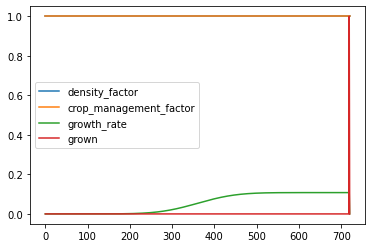

In [12]:
from jupyter_scripts import plot_agent
    
# Uncomment lines below to see the results:

# plot_agent(data, 'crew_habitat_small', 'storage', exclude=['n2', 'o2'])
# plot_agent(data, 'mushroom', 'flows', j=719)
plot_agent(data, 'mushroom', 'growth', exclude=['agent_step_num'])

# plot_group(data['crew_habitat_small']['storage'], exclude=['n2', 'o2'])
# (data['mushroom']['flows'], j=719)
# plot_group(data['mushroom']['growth'], exclude=['agent_step_num'])
# print(data.keys())
# print(data['mushroom'].keys())